# Proyek Klasifikasi Gambar: [Shoe vs Sandal vs Boot Image Dataset (15K Images)]
- **Nama:** [Nelson Lau]
- **Email:** [integralvektor@gmail.com]
- **ID Dicoding:** [MC006D5Y2185]

## Import Semua Packages/Library yang Digunakan

In [13]:
# Mengimpor libraries umum yang sering digunakan (Sumber:Dicoding)
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [14]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nelsonsby","key":"9f3a39dbe024fb71d33fbfddfc14825d"}'}

In [15]:
# Setup kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan extract dataset
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors
shoe-vs-sandal-vs-boot-dataset-15k-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Data Preprocessing


#### Split Dataset

In [16]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path ke dataset asli
data_source = '/content/Shoe vs Sandal vs Boot Dataset'

# Path folder hasil split
base_path = '/content/dataset_split'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'validation')
test_path = os.path.join(base_path, 'test')

# Daftar kelas
labels = ['Shoe', 'Sandal', 'Boot']

# Membuat folder train, val, test untuk masing-masing label
for split_dir in [train_path, val_path, test_path]:
    os.makedirs(split_dir, exist_ok=True)
    for label in labels:
        os.makedirs(os.path.join(split_dir, label), exist_ok=True)

# Mulai memproses pembagian file
for label in labels:
    label_dir = os.path.join(data_source, label)
    image_files = os.listdir(label_dir)

    # Filter file gambar
    image_files = [img for img in image_files if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Membagi data: 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(image_files, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Copy file ke direktori masing-masing
    for img in train_imgs:
        shutil.copy(os.path.join(label_dir, img), os.path.join(train_path, label, img))

    for img in val_imgs:
        shutil.copy(os.path.join(label_dir, img), os.path.join(val_path, label, img))

    for img in test_imgs:
        shutil.copy(os.path.join(label_dir, img), os.path.join(test_path, label, img))

print("Proses splitting dataset selesai!")


Proses splitting dataset selesai!


In [17]:
# Menampilkan jumlah gambar per kelas di setiap split
print("\nJumlah gambar setelah split:")

for split_name, split_dir in zip(['Train', 'Validation', 'Test'], [train_path, val_path, test_path]):
    print(f"\n{split_name}:")
    for label in labels:
        label_dir = os.path.join(split_dir, label)
        count = len([img for img in os.listdir(label_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {label}: {count} gambar")


Jumlah gambar setelah split:

Train:
  Shoe: 3500 gambar
  Sandal: 3500 gambar
  Boot: 3500 gambar

Validation:
  Shoe: 750 gambar
  Sandal: 750 gambar
  Boot: 750 gambar

Test:
  Shoe: 750 gambar
  Sandal: 750 gambar
  Boot: 750 gambar


✅ Dataset yang digunakan berisi minimal 10.000 gambar (Memenuhi kriteria ke-3 untuk mendapatkan 🌟5)

✅ Memiliki 3 buah kelas atau lebih (Memenuhi kriteria ke-5 untuk mendapatkan 🌟5)

### Data Augmentation & Image Data Generator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke dataset
train_dir = '/content/dataset_split/train'
val_dir = '/content/dataset_split/validation'
test_dir = '/content/dataset_split/test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validasi (hanya rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Untuk test (hanya rescale juga)
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # karena 3 kelas
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # supaya urutan file sama dengan prediksi
)



Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


### Plot gambar sampel untuk semua kelas

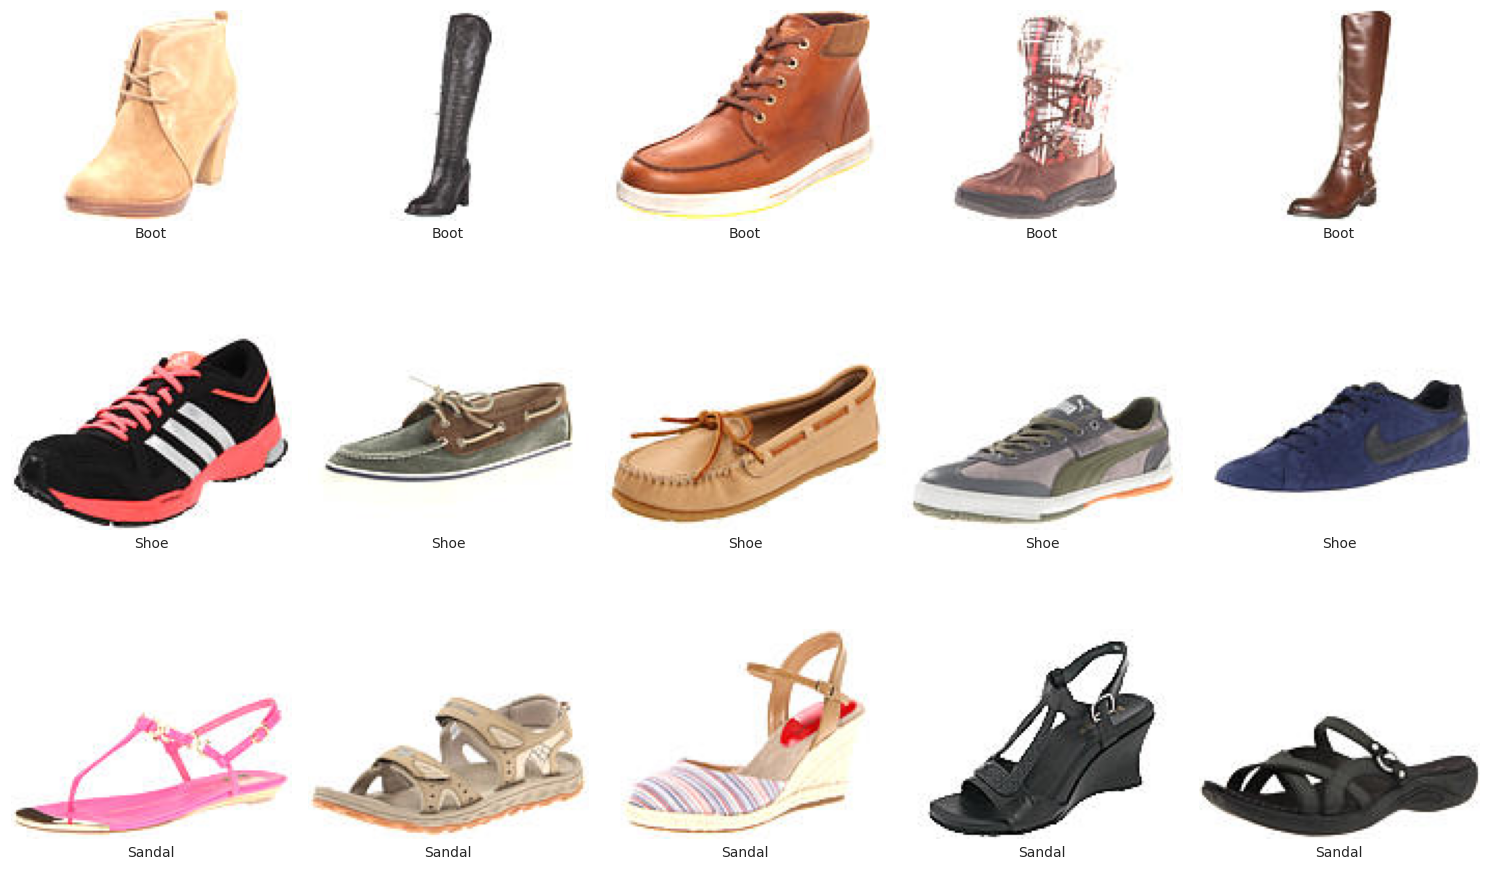

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
shoe_image = {}

# Tentukan path sumber train
path =  '/content/dataset_split/train'
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        shoe_image[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas
fig, axs = plt.subplots(len(shoe_image.keys()), 5, figsize=(15, 10))

for i, class_name in enumerate(shoe_image.keys()):
    images = np.random.choice(shoe_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # dataset ini gambar RGB, bukan grayscale
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


### Plot distribusi gambar di seluruh kelas

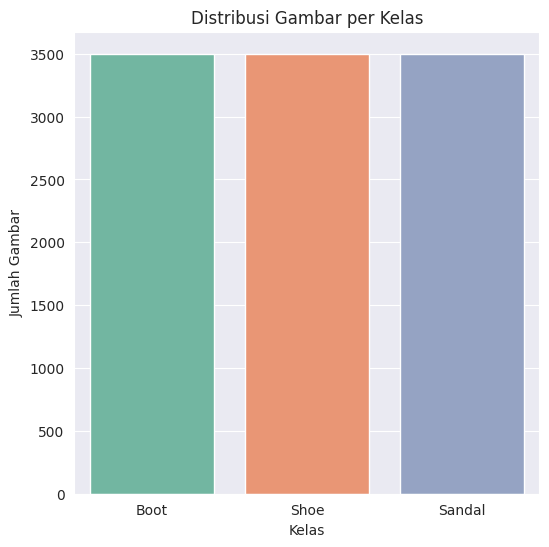

In [22]:
# Define source path
shoe_path =  '/content/dataset_split/train'

# Create lists to store filenames, filepaths, and labels
file_name = []
labels = []
full_path = []

# Get filenames, filepaths, and labels
for path, subdirs, files in os.walk(shoe_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Create DataFrame
distribution_shoe = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Plot distribution of images across classes
Label = distribution_shoe['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label, palette="Set2")
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()


## Modelling

In [23]:
# Custom Deep Convolutional Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
model_custom = Sequential()

# 1st Convolutional Block
model_custom.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(150,150,3)))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Convolutional Block
model_custom.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Convolutional Block
model_custom.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2,2)))

# 4th Convolutional Block
model_custom.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_custom.add(Flatten())

# Fully Connected Layers
model_custom.add(Dense(256, activation='relu'))
model_custom.add(Dropout(0.5))
model_custom.add(Dense(128, activation='relu'))
model_custom.add(Dropout(0.3))

# Output Layer
model_custom.add(Dense(3, activation='softmax'))  # 3 classes: boot, sandal, shoe

######################### Compile Model ################################
model_custom.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Model Summary
model_custom.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,205,187 (46.56 MB)

 Trainable params: 12,203,267 (46.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [24]:
# Ambil label dari train_generator
labels = train_generator.classes  # Ini array label numerik

# Hitung class weight otomatis
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_custom = compute_class_weight(class_weight='balanced',
                                            classes=np.unique(labels),
                                            y=labels)

# Ubah ke dictionary
class_weights_custom = dict(enumerate(class_weights_custom))
print("Class weights:", class_weights_custom)

# Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_custom.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

callbacks_custom = [early_stop, checkpoint, reduce_lr]

# FIT MODEL
history_custom = model_custom.fit(
    train_generator,
    epochs=30,               # kalau mau ubah, tinggal ganti
    batch_size=32,           # batch size tetap
    validation_data=val_generator,
    class_weight=class_weights_custom,
    callbacks=callbacks_custom
)


Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5595 - loss: 1.2963

329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - accuracy: 0.5597 - loss: 1.2954 - val_accuracy: 0.3356 - val_loss: 5.6356 - learning_rate: 1.0000e-04
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6718 - loss: 0.7829

329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.6718 - loss: 0.7829 - val_accuracy: 0.8169 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6985 - loss: 0.7201

329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.6986 - loss: 0.7200 - val_accuracy: 0.8138 - val_loss: 0.4669 - learning_rate: 1.0000e-04
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.7146 - loss: 0.6887 - val_accuracy: 0.8316 - val_loss: 0.5575 - learning_rate: 1.0000e-04
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7579 - loss: 0.6020

329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.7579 - loss: 0.6020 - val_accuracy: 0.8320 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.7738 - loss: 0.5609 - val_accuracy: 0.7969 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8225 - loss: 0.4759

329/329 ━━━━━━━━━━━━━━━━━━━━ 68s 208ms/step - accuracy: 0.8225 - loss: 0.4759 - val_accuracy: 0.8813 - val_loss: 0.3911 - learning_rate: 1.0000e-04
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8367 - loss: 0.4475

329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.8367 - loss: 0.4474 - val_accuracy: 0.9222 - val_loss: 0.2264 - learning_rate: 1.0000e-04
Epoch 9/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8469 - loss: 0.4172

329/329 ━━━━━━━━━━━━━━━━━━━━ 67s 205ms/step - accuracy: 0.8469 - loss: 0.4172 - val_accuracy: 0.9187 - val_loss: 0.2106 - learning_rate: 1.0000e-04
Epoch 10/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 199ms/step - accuracy: 0.8562 - loss: 0.3925 - val_accuracy: 0.8938 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 11/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.8818 - loss: 0.3357 - val_accuracy: 0.9302 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 12/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8824 - loss: 0.3476

329/329 ━━━━━━━━━━━━━━━━━━━━ 81s 200ms/step - accuracy: 0.8824 - loss: 0.3476 - val_accuracy: 0.9351 - val_loss: 0.1822 - learning_rate: 1.0000e-04
Epoch 13/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9009 - loss: 0.2948

329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.9009 - loss: 0.2947 - val_accuracy: 0.9431 - val_loss: 0.1791 - learning_rate: 1.0000e-04
Epoch 14/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9045 - loss: 0.2882

329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.9045 - loss: 0.2882 - val_accuracy: 0.9409 - val_loss: 0.1779 - learning_rate: 1.0000e-04
Epoch 15/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.9060 - loss: 0.2796 - val_accuracy: 0.8249 - val_loss: 0.4468 - learning_rate: 1.0000e-04
Epoch 16/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9172 - loss: 0.2528 - val_accuracy: 0.9196 - val_loss: 0.1905 - learning_rate: 1.0000e-04
Epoch 17/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9109 - loss: 0.2673 - val_accuracy: 0.9067 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 18/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 202ms/step - accuracy: 0.9277 - loss: 0.2156 - val_accuracy: 0.9396 - val_loss: 0.1852 - learning_rate: 2.0000e-05
Epoch 19/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9412 - loss: 0.1716

329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.9412 - loss: 0.1716 - val_accuracy: 0.9689 - val_loss: 0.0945 - learning_rate: 2.0000e-05
Epoch 20/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.9523 - loss: 0.1525 - val_accuracy: 0.9653 - val_loss: 0.0965 - learning_rate: 2.0000e-05
Epoch 21/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9458 - loss: 0.1694 - val_accuracy: 0.9667 - val_loss: 0.1025 - learning_rate: 2.0000e-05
Epoch 22/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9443 - loss: 0.1605

329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.9443 - loss: 0.1605 - val_accuracy: 0.9702 - val_loss: 0.0898 - learning_rate: 2.0000e-05
Epoch 23/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.9538 - loss: 0.1488 - val_accuracy: 0.9684 - val_loss: 0.0989 - learning_rate: 2.0000e-05
Epoch 24/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - accuracy: 0.9524 - loss: 0.1472 - val_accuracy: 0.9676 - val_loss: 0.1041 - learning_rate: 2.0000e-05
Epoch 25/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 200ms/step - accuracy: 0.9522 - loss: 0.1455 - val_accuracy: 0.9693 - val_loss: 0.0966 - learning_rate: 2.0000e-05
Epoch 26/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9523 - loss: 0.1333

329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.9523 - loss: 0.1333 - val_accuracy: 0.9729 - val_loss: 0.0857 - learning_rate: 4.0000e-06
Epoch 27/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9605 - loss: 0.1321

329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9605 - loss: 0.1321 - val_accuracy: 0.9742 - val_loss: 0.0851 - learning_rate: 4.0000e-06
Epoch 28/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9590 - loss: 0.1245

329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 202ms/step - accuracy: 0.9591 - loss: 0.1245 - val_accuracy: 0.9733 - val_loss: 0.0845 - learning_rate: 4.0000e-06
Epoch 29/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9604 - loss: 0.1155 - val_accuracy: 0.9724 - val_loss: 0.0885 - learning_rate: 4.0000e-06
Epoch 30/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.9604 - loss: 0.1234 - val_accuracy: 0.9733 - val_loss: 0.0870 - learning_rate: 4.0000e-06


✅Mengimplementasikan Callback (Memenuhi kriteria ke-1 untuk mendapatkan 🌟5)

✅Akurasi pada training set dan testing set minimal 95% (Memenuhi kriteria ke-4 untuk mendapatkan 🌟5)

## Evaluasi dan Visualisasi

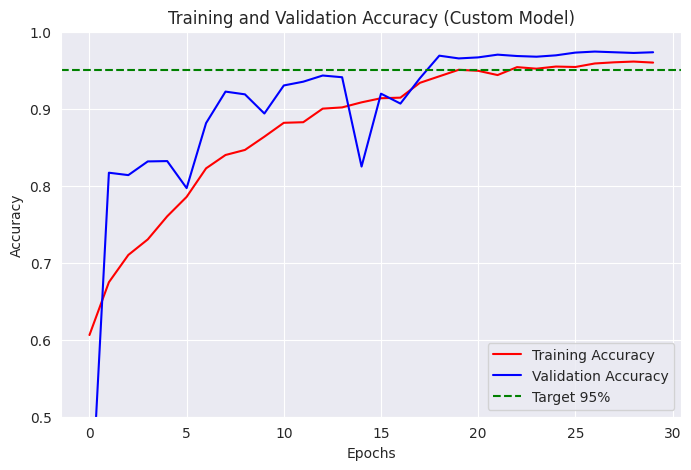

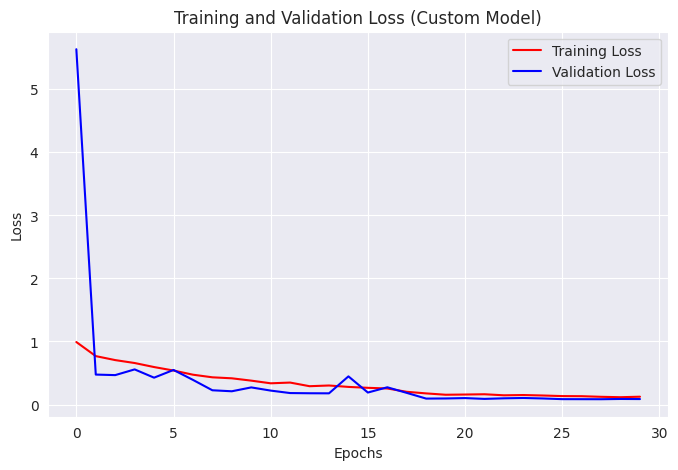

In [25]:
# Ambil nilai akurasi dan loss dari history_custom
acc = history_custom.history['accuracy']
val_acc = history_custom.history['val_accuracy']
loss = history_custom.history['loss']
val_loss = history_custom.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.axhline(y=0.95, color='g', linestyle='--', label='Target 95%')  # Tambah garis horizontal
plt.title('Training and Validation Accuracy (Custom Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)  # Biar 0.95 kelihatan
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss (Custom Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


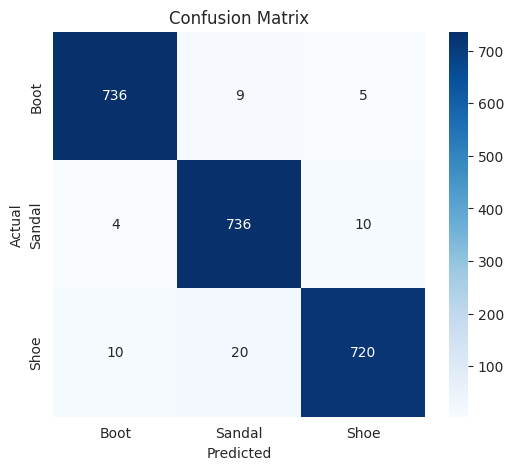


Classification Report:

              precision    recall  f1-score   support

        Boot     0.9813    0.9813    0.9813       750
      Sandal     0.9621    0.9813    0.9716       750
        Shoe     0.9796    0.9600    0.9697       750

    accuracy                         0.9742      2250
   macro avg     0.9743    0.9742    0.9742      2250
weighted avg     0.9743    0.9742    0.9742      2250



In [26]:
# Reset generator
test_generator.reset()

# Prediksi
preds = model_custom.predict(test_generator, verbose=0)
pred_labels = np.argmax(preds, axis=1)  # ambil label prediksi multiclass

# Ambil label asli
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['Boot', 'Sandal', 'Shoe']

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))


## Konversi Model

In [27]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [28]:
# Simpan model ke TFJS
import tensorflowjs as tfjs

# Simpan model_custom ke folder 'model_tfjs'
tfjs_target_dir = '/content/model_tfjs'
tfjs.converters.save_keras_model(model_custom, tfjs_target_dir)

print(f"Model berhasil disimpan di {tfjs_target_dir}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan di /content/model_tfjs


In [29]:
import tensorflow as tf

# Konversi model_custom ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_custom)
tflite_model = converter.convert()

# Simpan ke file
with open('model_custom.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi dan disimpan sebagai model_custom.tflite!")


Saved artifact at '/tmp/tmpmgp5wfg9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_172')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140559985525200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985537680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985535376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985536720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985534992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985537488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985539984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985540368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985535568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985533840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405599855

In [30]:
# Simpan model_custom ke format SavedModel (baru)
saved_model_dir = '/content/saved_model_custom'
model_custom.export(saved_model_dir)

print(f"Model berhasil diexport ke format SavedModel di {saved_model_dir}")


Saved artifact at '/content/saved_model_custom'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_172')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140559985525200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985537680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985535376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985536720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985534992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985537488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985539984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985540368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985535568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559985533840: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

## Inference (Optional)

Saving test3.jpg to test3.jpg
0
Predicted class: Boot
Prediction probabilities: [[9.9763906e-01 8.4313541e-04 1.5178225e-03]]


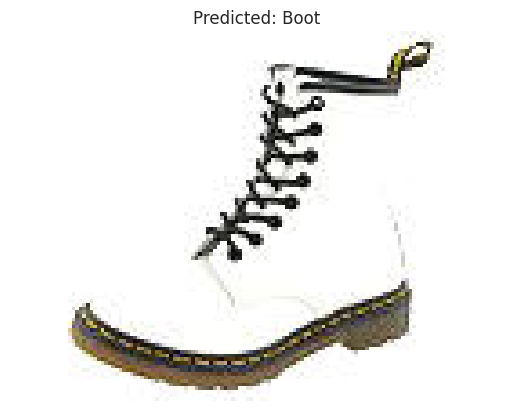

In [33]:
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.layers import TFSMLayer
from google.colab import files
import matplotlib.pyplot as plt

# Step 1: Upload gambar
uploaded = files.upload()

# Ambil nama file yang diupload
image_path = list(uploaded.keys())[0]

# Step 2: Load model dari SavedModel pakai TFSMLayer
model = TFSMLayer('/content/saved_model_custom', call_endpoint='serving_default')

# Step 3: Fungsi untuk preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((150, 150))
    img_array = np.array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension
    return img_array

# Step 4: Preprocess gambar
processed_image = preprocess_image(image_path)

# Step 5: Inference

raw_output = model(processed_image)   # ini dict
predictions = raw_output['output_0'].numpy()  # Ambil nilai tensor dan ubah jadi array
predicted_class = np.argmax(predictions)  # Ambil kelas dengan nilai probabilitas tertinggi
print(predicted_class)
class_labels = ['Boot', 'Sandal', 'Shoes']

# Step 6: Output hasil
print("Predicted class:", class_labels[predicted_class])
print("Prediction probabilities:", predictions)

# Step 7: Tampilkan gambarnya
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.show()


✅Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel), (Memenuhi kriteria ke-6 untuk mendapatkan 🌟5)

### Kriteria yang dicapai:


1.   ✅Mengimplementasikan Callback
2.   ✅Gambar-gambar pada dataset asli memiliki resolusi yang tidak seragam (Tanpa preprocessing)
3.   ✅Dataset yang digunakan berisi minimal 10000 gambar.
4.    ✅Akurasi pada training set dan testing set minimal 95%.

5.  ✅Memiliki 3 buah kelas atau lebih.
6. ✅Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel).

